# CIS 8005: Data Programming Group Project
## Members: Austin Gregory, Alif Dastegir, Prashanth Kadari, Linda Ackah-Mensah

### <strong>Goal:</strong> Identify which health and social indicators are most strongly linked to county‑level poverty and visualize the relationships; then train several classifiers to predict a county’s poverty quartile based on that counties health and social indicators and select a best model.

In [90]:
import pandas as pd
import numpy as np
import json
import datetime as dt
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer  # to apply different preprocessing to different columns
from sklearn.pipeline import Pipeline  # to chain preprocessing and model steps
from sklearn.impute import SimpleImputer   # replace missing values with median
from sklearn.preprocessing import StandardScaler # standardize features
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate # stratified k-fold cross-validation to maintain class distribution in folds
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

## Extract, Tranform, and Load Data

## Cleaning Poverty Data

### Querying Poverty Data via US Census API Call

In [72]:
county_url = 'https://api.census.gov/data/timeseries/poverty/saipe.html?get=YEAR,NAME,STATE,STABREV,COUNTY,SAEMHI_PT,SAEPOV0_17_PT,SAEPOV0_17_MOE,SAEPOVALL_PT,SAEPOVALL_MOE,SAEPOVU_0_17,SAEPOVU_ALL&for=county:*&for=state:*&YEAR=2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023&key=ebe8af9d05c22f5688121b5cfaf9b33ddc877769'
county_r = requests.get(county_url)
county_json = county_r.json()

state_url = 'https://api.census.gov/data/timeseries/poverty/saipe.html?get=YEAR,NAME,STATE,STABREV,COUNTY,SAEMHI_PT,SAEPOV0_17_PT,SAEPOV0_17_MOE,SAEPOVALL_PT,SAEPOVALL_MOE,SAEPOVU_0_17,SAEPOVU_ALL&for=state:*&YEAR=2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023&key=ebe8af9d05c22f5688121b5cfaf9b33ddc877769'
state_r = requests.get(state_url)
state_json = state_r.json()

### Cleaning the Poverty Data and Returning Cleaned DataFrame

In [73]:
# function to transform json data into cleaned pandas dataframe
def poverty_data_json_to_df(county_json, state_json):
    def clean_df(df):
        # Setting columns to first row of data and subsequently deleting the row
        df = df.iloc[:, :12]
        df.columns = df.iloc[0]
        df.drop(index = 0, inplace = True) # drop first row
        df.reset_index(drop = True, inplace = True)
        return df
    
    df1 = pd.DataFrame.from_dict(county_json)
    df1 = clean_df(df1)
    df2 = pd.DataFrame.from_dict(state_json)
    df2 = clean_df(df2)
    
    df = pd.concat([df1, df2], axis = 0, ignore_index = True)
    
    # Renaming columns
    df.rename(mapper = {
        "YEAR": "Year",
        "NAME": "County",
        "STATE": "State",
        "STABREV": "State Abbreviation",
        "COUNTY": "County FIPS",
        "SAEMHI_PT": "Median HH Income Estimate",
        "SAEPOV0_17_PT": "Ages 0-17 in Poverty",
        "SAEPOV0_17_MOE": "Ages 0-17 in Poverty MOE",
        "SAEPOVALL_PT": "All Ages in Poverty",
        "SAEPOVALL_MOE": "All Ages in Poverty MOE",
        "SAEPOVU_0_17": "Ages 0-17 in Poverty Universe",
        "SAEPOVU_ALL": "All Ages in Poverty Universe" 
        }, axis = "columns", inplace = True)
    
    # Combining State and County FIPS to create a unique identifier for each county
    df['County FIPS'] = df['State'] + df['County FIPS']

    # Redoing the column datatypes so not all columns are objects
    df = df.astype({'Year': 'datetime64[ns]', 'Median HH Income Estimate': 'float64', 'Ages 0-17 in Poverty': 'float64', 
                    'Ages 0-17 in Poverty MOE': 'float64', 'All Ages in Poverty': 'float64', 'All Ages in Poverty MOE': 'float64', 
                    'Ages 0-17 in Poverty Universe': 'float64', 'All Ages in Poverty Universe': 'float64'})

    # Creating columns for poverty percentages
    df["Ages 0-17 in Poverty %"] = df['Ages 0-17 in Poverty'] / df['Ages 0-17 in Poverty Universe']
    df["All Ages in Poverty %"] = df['All Ages in Poverty'] / df['All Ages in Poverty Universe']
    
    # dropping rows with missing data, sorting values, and resetting index
    df.dropna(subset = df.columns[4:], inplace = True)
    df.sort_values(by = ['County FIPS', 'Year'], inplace = True)
    df.reset_index(drop = True, inplace = True)
    
    # creating a column to calculate the poverty quartile that a county falls into for each year
    def assign_quartiles(s):
        return pd.qcut(s, 4, labels=[1, 2, 3, 4])
    df['Poverty Quartile'] = df.groupby('Year')['All Ages in Poverty %'].transform(assign_quartiles)

    # Rearranging columns in more clean order
    df = df[['Year', 'State Abbreviation', 'County', 'County FIPS', 'Median HH Income Estimate', 'Ages 0-17 in Poverty', 'Ages 0-17 in Poverty MOE', 'Ages 0-17 in Poverty Universe', 'Ages 0-17 in Poverty %', 'All Ages in Poverty', 'All Ages in Poverty MOE', 'All Ages in Poverty Universe', 'All Ages in Poverty %', 'Poverty Quartile']]
            
    return df

povertyData = poverty_data_json_to_df(county_json, state_json)
povertyData.head(5)

C:\Users\austin.gregory\AppData\Local\Temp\ipykernel_7376\3745420912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index = 0, inplace = True) # drop first row
C:\Users\austin.gregory\AppData\Local\Temp\ipykernel_7376\3745420912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index = 0, inplace = True) # drop first row


,Year,State Abbreviation,County,County FIPS,Median HH Income Estimate,Ages 0-17 in Poverty,Ages 0-17 in Poverty MOE,Ages 0-17 in Poverty Universe,Ages 0-17 in Poverty %,All Ages in Poverty,All Ages in Poverty MOE,All Ages in Poverty Universe,All Ages in Poverty %,Poverty Quartile
0,2004-01-01,AL,Alabama,01000,37062.0,245017.0,18865.0,1082849.0,0.226271,717483.0,41491.0,4463171.0,0.160756,3
1,2005-01-01,AL,Alabama,01000,36936.0,260919.0,8025.0,1072696.0,0.243237,749592.0,14919.0,4429785.0,0.169216,3
2,2006-01-01,AL,Alabama,01000,38811.0,253314.0,7292.0,1097080.0,0.230898,743556.0,13259.0,4482161.0,0.165892,3
3,2007-01-01,AL,Alabama,01000,40596.0,261151.0,8605.0,1105467.0,0.236236,750197.0,15498.0,4506569.0,0.166467,3
4,2008-01-01,AL,Alabama,01000,42586.0,244661.0,8653.0,1105914.0,0.221230,721875.0,14892.0,4541753.0,0.158942,3


## Clean Health Data & Merge with Poverty Data

### State & County Health Data Load and Tranformations for Finalized DataFrame

In [74]:
a = pd.read_excel('Health Datasets/2023 County Health Rankings Data - v2.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
b = pd.read_excel('Health Datasets/2022 County Health Rankings Data - v1.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
c = pd.read_excel('Health Datasets/2021 County Health Rankings Data - v1.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
d = pd.read_excel('Health Datasets/2020 County Health Rankings Data - v2.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
e = pd.read_excel('Health Datasets/2019 County Health Rankings Data - v3.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
f = pd.read_excel('Health Datasets/2018 County Health Rankings Data - v2.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
g = pd.read_excel('Health Datasets/2017CountyHealthRankingsData.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
h = pd.read_excel('Health Datasets/2016 County Health Rankings Data - v3.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
i = pd.read_excel('Health Datasets/2015 County Health Rankings Data - v3.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)
j = pd.read_excel('Health Datasets/2014 County Health Rankings Data - v6.xlsx', sheet_name=['Ranked Measure Data', 'Additional Measure Data'], skiprows=1)

In [75]:
# mapping of column names for consistency across the different years of data and easier readability
rename_map = {
    "YPLL Rate": "Years of Potential Life Lost Rate",
    "% Fair/Poor": "% Fair or Poor Health",
    "Physically Unhealthy Days": "Average Physically Unhealthy Days",
    "Average Number of Physically Unhealthy Days": "Average Physically Unhealthy Days",
    "Mentally Unhealthy Days": "Average Mentally Unhealthy Days",
    "Average Number of Mentally Unhealthy Days": "Average Mentally Unhealthy Days",
    "% Smokers": "% Adults Reporting Currently Smoking",
    "% Excessive Drinking": "% Excessive Drinking",
    "% Physically Inactive": "% Physically Inactive",
    "% Obese": "% Adults with Obesity",
    "% Diabetic": "% Adults with Diabetes",
    "Teen Birth Rate": "Teen Birth Rate",
    "% Uninsured": "% Uninsured",
    "PCP Ratio": "Primary Care Physicians Ratio",
    "Dentist Ratio": "Dentist Ratio",
    "MHP Ratio": "Mental Health Provider Ratio",
    "Preventable Hosp. Rate": "Preventable Hospitalization Rate",    
    "ACSC Rate": "Preventable Hospitalization Rate",    
    "High School Graduation Rate": "% Completed High School",
    "Graduation Rate": "% Completed High School",
    "% High School Graduates": "% Completed High School",
    "% Some College": "% Some College",
    "% Unemployed": "% Unemployed",
    "% Severe Housing Problems": "% Severe Housing Problems",
    "% Food Insecure": "% Food Insecure",
    "Income Ratio": "Income Inequality",
    "% Single-Parent Households": "% Children in Single-Parent Households"
}

dataElementsValues = list(rename_map.values())

In [76]:
# function to merge health data sets
rankedMeasureData, additionalMeasureData = pd.DataFrame(), pd.DataFrame()
for _ in [a, b, c, d, e, f, g, h, i, j]:
    # renaming columns to create uniformity
    ranked = _['Ranked Measure Data'].rename(columns=rename_map)
    additional = _['Additional Measure Data'].rename(columns=rename_map)

    rankedMeasureData = pd.concat([rankedMeasureData, ranked], ignore_index=True)
    additionalMeasureData = pd.concat([additionalMeasureData, additional], ignore_index=True)

# function to clean health data from different sheets in the excel file

def clean_health_data(elements, df1, df2):
    
    # merging the two health data sheets into one dataframe if the column is found in the DataElements sheet
    for col in df1.iloc[:, 4:].columns:
        if col not in elements:
            df1.drop(columns=col, inplace=True)
    for col in df2.iloc[:, 4:].columns:
        if col not in elements:
            df2.drop(columns=col, inplace=True)

    df = pd.merge(df1, df2, how='outer', on=['Year','FIPS','State','County'])
    df.dropna(how='all', inplace=True)

    # setting Year column to datetime format to match poverty data year format
    df['Year'] = pd.to_datetime(df['Year'].astype('Int64'), format='%Y', errors='coerce')
    
    # for years 2014 - 2018, need to multiply the Preventable Hospitalization Rate column by 100 to match the format in years 2019 - 2023
    df.loc[df['Year'].dt.year <= 2018, 'Preventable Hospitalization Rate'] *= 100
    
    # removing rows with missing year values or county values [missing county values equate to state totals, which are not available in years 2014 - 2019] and removing rows where all values are missing
    df = df.dropna(subset=['Year', 'County']).reset_index(drop=True)
    df = df.dropna(how='all').reset_index(drop=True)

    # setting FIPS column to 5 digit string with leading zeros if necessary to match FIPS in poverty data and filtering out counties not in poverty data
    df['FIPS'] = df['FIPS'].astype(int).astype(str).str.zfill(5)
    df = df[df['FIPS'].isin(povertyData['County FIPS'])]

    # convert ratio-like columns (values like "1521:1") to numeric (people per provider)
    ratio_cols = ['Primary Care Physicians Ratio', 'Dentist Ratio', 'Mental Health Provider Ratio']

    # function to parse ratio-like values
    def _parse_ratio(val):
        if pd.isna(val):
            return np.nan
        if isinstance(val, (int, float, np.number)):
            return val
        s = str(val).strip()
        if not s or s.lower() in {'na', 'n/a', 'nan', 'inf', '-inf'}:
            return np.nan
        s = s.replace(',', '').replace(' ', '')
        if ':' in s:
            parts = [p for p in s.split(':') if p != '']
            if len(parts) >= 2:
                try:
                    num = float(parts[0])
                    den = float(parts[1]) if float(parts[1]) != 0 else np.nan
                    return num / den if den and den != 0 else np.nan
                except:
                    pass
        # fallback: strip non-numeric trailing chars
        cleaned = ''.join(ch for ch in s if (ch.isdigit() or ch == '.' or ch == '-'))
        try:
            return float(cleaned)
        except:
            return np.nan

    for col in ratio_cols:
        if col in df.columns:
            df[col] = df[col].apply(_parse_ratio).astype('float64')

    # if value is null, calculate the average for that state for that year and fill in the missing value
    value_cols = df.columns[4:]
    state_year_avg = df.groupby(['State', 'Year'])[value_cols].transform('mean')
    df[value_cols] = df[value_cols].fillna(state_year_avg)

    # since there is no data for the Income Ratio column in 2014, backfilling it with that county's 2015 value
    df['Income Inequality'] = df.groupby('FIPS')['Income Inequality'].transform('bfill')

    return df

healthData = clean_health_data(dataElementsValues, rankedMeasureData, additionalMeasureData)
healthData.head(5)


,Year,FIPS,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Physically Unhealthy Days,Average Mentally Unhealthy Days,% Adults Reporting Currently Smoking,% Adults with Obesity,...,% Completed High School_x,% Some College,% Unemployed,Income Inequality,% Children in Single-Parent Households,% Severe Housing Problems,% Adults with Diabetes,% Food Insecure,% Completed High School_y,% Uninsured_y
0,2014-01-01,01001,Alabama,Autauga,8376.42,22.8,5.1,3.6,21.7,30.5,...,80.000000,54.732198,6.452119,4.171514,30.124949,11.663286,11.8,13.6,NaN,17.962919
1,2014-01-01,01003,Alabama,Baldwin,7770.16,12.7,3.3,3.8,20.6,26.6,...,74.000000,61.784534,6.765939,4.417148,27.879987,13.486866,11.8,13.1,NaN,20.924300
2,2014-01-01,01005,Alabama,Barbour,9458.14,23.4,4.8,4.3,25.1,37.3,...,60.640060,41.407089,11.179577,5.473986,55.907877,16.845329,14.2,23.0,NaN,24.216186
3,2014-01-01,01007,Alabama,Bibb,11543.90,17.9,4.7,5.1,25.9,34.3,...,73.000000,44.198175,7.640647,4.513786,39.281642,9.543011,11.1,15.8,NaN,20.007816
4,2014-01-01,01009,Alabama,Blount,8505.64,24.2,5.9,3.9,21.3,30.4,...,81.030856,46.276054,6.218226,3.983751,25.336291,12.594031,14.0,12.1,NaN,22.684082


In [ ]:
# merging health data with poverty data
def merge_health_and_poverty(df, povertyData):
    df = pd.merge(df, 
                    povertyData[['Year', 'County FIPS', 'Median HH Income Estimate', 'Ages 0-17 in Poverty %', 'All Ages in Poverty %', 'Poverty Quartile']], 
                    how='left', left_on=['Year', 'FIPS'], right_on=['Year', 'County FIPS'])
    return df

allHealthData = merge_health_and_poverty(healthData, povertyData).drop(columns=['County FIPS', '% Uninsured_y', '% Completed High School_y']).rename(columns={'% Uninsured_x': '% Uninsured', '% Completed High School_x': '% Completed High School'})

# changing year from datetime to int year only for easier visualizations down the line
allHealthData['Year'] = allHealthData['Year'].dt.year

allHealthData.head(5)

,Year,FIPS,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Physically Unhealthy Days,Average Mentally Unhealthy Days,% Adults Reporting Currently Smoking,% Adults with Obesity,...,% Unemployed,Income Inequality,% Children in Single-Parent Households,% Severe Housing Problems,% Adults with Diabetes,% Food Insecure,Median HH Income Estimate,Ages 0-17 in Poverty %,All Ages in Poverty %,Poverty Quartile
0,2014,01001,Alabama,Autauga,8376.42,22.8,5.1,3.6,21.7,30.5,...,6.452119,4.171514,30.124949,11.663286,11.8,13.6,54366.0,0.181351,0.131213,2
1,2014,01003,Alabama,Baldwin,7770.16,12.7,3.3,3.8,20.6,26.6,...,6.765939,4.417148,27.879987,13.486866,11.8,13.1,49626.0,0.197620,0.130163,2
2,2014,01005,Alabama,Barbour,9458.14,23.4,4.8,4.3,25.1,37.3,...,11.179577,5.473986,55.907877,16.845329,14.2,23.0,34971.0,0.380520,0.253855,4
3,2014,01007,Alabama,Bibb,11543.90,17.9,4.7,5.1,25.9,34.3,...,7.640647,4.513786,39.281642,9.543011,11.1,15.8,39546.0,0.268097,0.180957,3
4,2014,01009,Alabama,Blount,8505.64,24.2,5.9,3.9,21.3,30.4,...,6.218226,3.983751,25.336291,12.594031,14.0,12.1,45567.0,0.240823,0.174963,3


### Cell immediately beneath this was used to help identify missing data and other data anamolies that were then corrected in two functions above 

In [78]:
# count nulls per column, grouped by year to evaluate data completeness
null_counts_by_year = allHealthData.isna().groupby(allHealthData['Year']).sum()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(null_counts_by_year)

,Year,FIPS,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Physically Unhealthy Days,Average Mentally Unhealthy Days,% Adults Reporting Currently Smoking,% Adults with Obesity,% Physically Inactive,% Excessive Drinking,Teen Birth Rate,% Uninsured,Primary Care Physicians Ratio,Dentist Ratio,Mental Health Provider Ratio,Preventable Hospitalization Rate,% Completed High School,% Some College,% Unemployed,Income Inequality,% Children in Single-Parent Households,% Severe Housing Problems,% Adults with Diabetes,% Food Insecure,Median HH Income Estimate,Ages 0-17 in Poverty %,All Ages in Poverty %,Poverty Quartile
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4
2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,6
2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,6
2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2022,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,9,9


## Visual Analysis:

Calculated variables for easier plotting

In [79]:
# potential features of interest for plotting
features = [
    "All Ages in Poverty %", 
    "% Uninsured",
    "Income Inequality",
    "Years of Potential Life Lost Rate",
    "Primary Care Physicians Ratio",
    "Preventable Hospitalization Rate",
    "% Fair or Poor Health",
    "% Adults with Diabetes",
    "% Food Insecure",
    "% Completed High School",
    "% Severe Housing Problems"
]

# year bounds
first_year, last_year = allHealthData['Year'].min(), allHealthData['Year'].max()
years = list(range(first_year, last_year + 1)) # will act as the x-axis for time series plots

# yearly means
yearly_means = (
    allHealthData
    .groupby('Year', as_index=False)[features]
    .mean(numeric_only=True)
)

# yearly means by poverty quartile
yq_means = (
    allHealthData
    .groupby(['Year','Poverty Quartile'], as_index=False)[features]
    .mean(numeric_only=True)
)

first_year_df = allHealthData[allHealthData['Year'] == 2014]
last_year_df = allHealthData[allHealthData['Year'] == 2023]

C:\Users\austin.gregory\AppData\Local\Temp\ipykernel_7376\3661948838.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Year','Poverty Quartile'], as_index=False)[features]


Loading in cartographic shape file for choropleth map visual

In [80]:
counties = gpd.read_file('County Geo File/cb_2023_us_county_5m/cb_2023_us_county_5m.shp').rename(columns={'GEOID': 'FIPS'})
states_to_exclude = ['02', '15', '60', '66', '69', '72', '78']  # AK, HI, AS, GU, MP, PR, VI
counties = counties[~counties['STATEFP'].isin(states_to_exclude)].reset_index(drop=True)

All functions for the visuals

In [81]:
# plotting functions to repeatedly use for different features 

# plot trend over time by poverty quartile
def plot_trend_by_quartile(yq_means, feature):
    plt.figure(figsize=(10,6))
    for q in sorted(yq_means['Poverty Quartile'].dropna().unique()):
        sub = yq_means[yq_means['Poverty Quartile'] == q]
        y = sub[feature].values
        x = sub['Year'].values
        plt.plot(x, y, marker='o', label=f"Quartile {int(q)}")
    plt.title(f"{feature} - By Poverty Quartile ({first_year}-{last_year})")
    plt.xlabel("Year"); plt.ylabel(feature)
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# scatter plot with trend line for a given feature in a given year
def plot_scatter_poverty_with_trend(df_year, feature):
    
    sns.regplot(
        x = "All Ages in Poverty %",
        y = feature,
        data = df_year,
        scatter_kws = {'alpha':0.4, 's':15},
        line_kws = {'color':'mediumseagreen', 'linewidth':2}    
    )
    
    year = int(df_year['Year'].iloc[0])
    
    plt.title(f"Poverty vs {feature} - {year}")
    plt.xlabel("All Ages in Poverty %"); plt.ylabel(feature)
    plt.grid(True, alpha=0.3) 
    plt.tight_layout()
    plt.show()

# standard function to create a correlation heatmap
def create_correlation_heatmap(data, title):
    plt.figure(figsize=(12, 8))
    corr = data.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title(title)
    plt.show()

# function to plot extreme values (top and bottom N) for a given feature in a given year by state
def plot_extremes_bar(df_year, feature, top=5, bottom=5):
    sub = df_year[['State', feature]].dropna()
    topk = sub.nlargest(top, feature)
    botk = sub.nsmallest(bottom, feature)

    # top 4 states
    plt.figure(figsize=(10, max(4, 0.4*len(topk)+1)))
    labels = topk['State'].tolist()
    plt.barh(labels, topk[feature].values)
    plt.title(f"Highest {feature} - {int(df_year['Year'].iloc[0])}")
    plt.xlabel(feature)
    plt.gca().invert_yaxis() # inverts y-axis so highest values are at the top
    plt.tight_layout(); plt.show()
    
    # bottom 4 states
    plt.figure(figsize=(10, max(4, 0.4*len(botk)+1)))
    labels = botk['State'].tolist()
    plt.barh(labels, botk[feature].values)
    plt.title(f"Lowest {feature} - {int(df_year['Year'].iloc[0])}")
    plt.xlabel(feature)
    plt.gca().invert_yaxis() # inverts y-axis so highest values are at the top
    plt.tight_layout(); plt.show()

def plot_feature_importance_simple(df_year, target, candidate_features):
    sub = df_year[candidate_features + [target]].dropna()
    X = sub[candidate_features].values; y = sub[target].values
    Xs = (X - X.mean(axis=0)) / np.where(X.std(axis=0)==0, 1, X.std(axis=0))
    ys = (y - y.mean()) / (y.std() if y.std()!=0 else 1)
    beta = np.linalg.pinv(Xs) @ ys
    order = np.argsort(-np.abs(beta))
    feats = [candidate_features[i] for i in order]; vals = beta[order]
    plt.figure(figsize=(10, max(5, 0.4*len(feats)+1)))
    plt.barh(np.arange(len(feats)), vals); plt.yticks(np.arange(len(feats)), feats)
    plt.gca().invert_yaxis()
    plt.xlabel("Standardized coefficient (not causal)")
    plt.title(f"Which features most align with {target} in {int(df_year['Year'].iloc[0])}?")
    plt.tight_layout(); plt.show()
    
# Single-year choropleth - poverty by quartile
def choropleth_single_year(counties_gdf, df_metric_year, cmap='Reds'):
    merged = counties_gdf.merge(df_metric_year[['FIPS', 'Poverty Quartile']], on='FIPS', how='left')
    fig, ax = plt.subplots(figsize=(12, 7))
    merged.plot(column='Poverty Quartile', ax=ax, legend=True, categorical=True, linewidth=0.2, cmap=cmap, edgecolor='black')
    ax.set_axis_off()
    ax.set_title(f"Poverty Quartile by County — {df_metric_year['Year'].iloc[0]}")
    plt.tight_layout()
    plt.show()

Execution of the functions to produce the visuals

The below choropleth shows the poverty quartile by county and 
evidencing that the southern United States has higher levels of poverty.


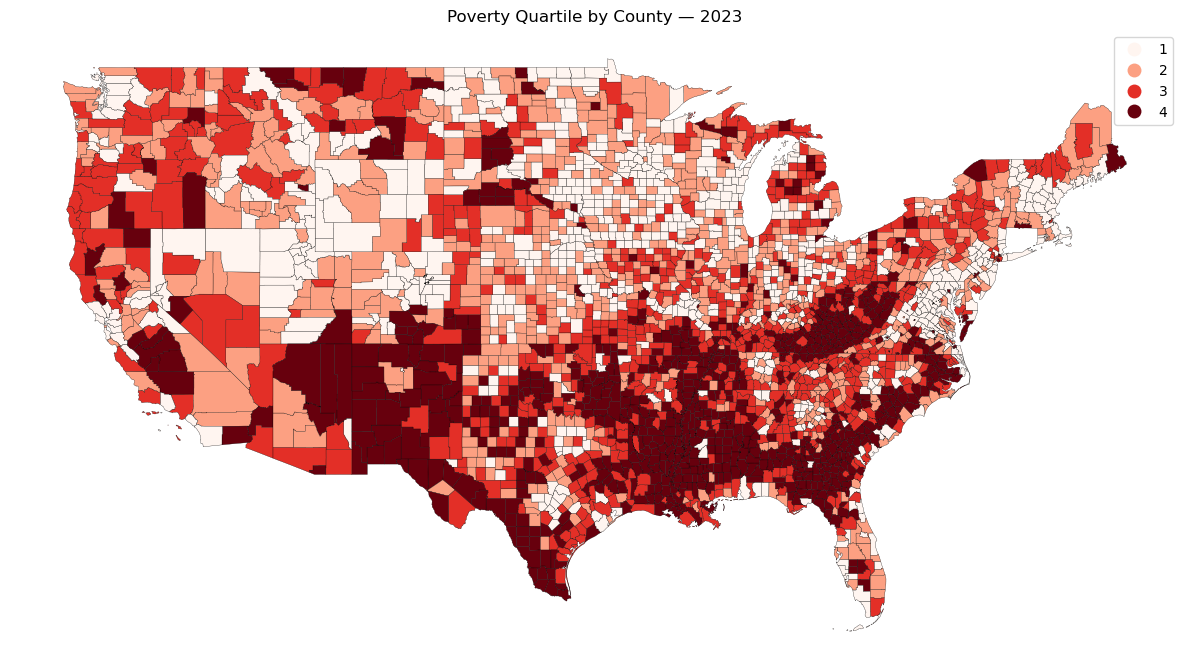

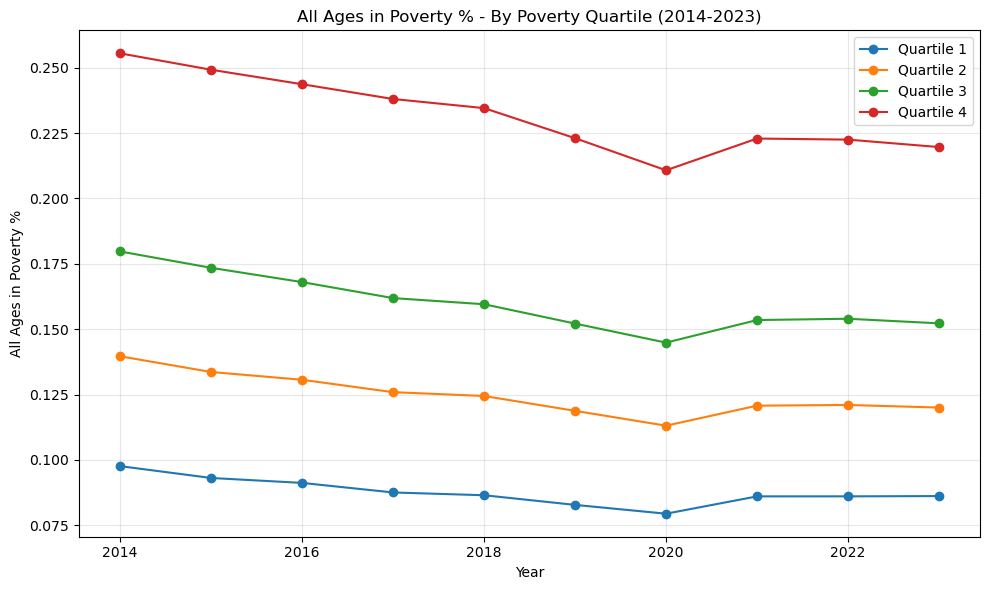

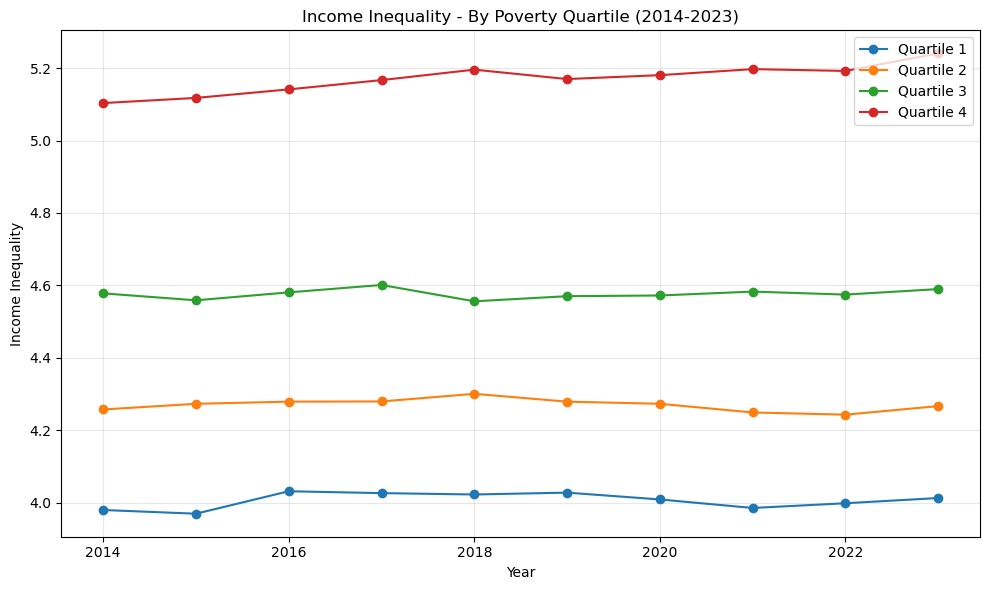

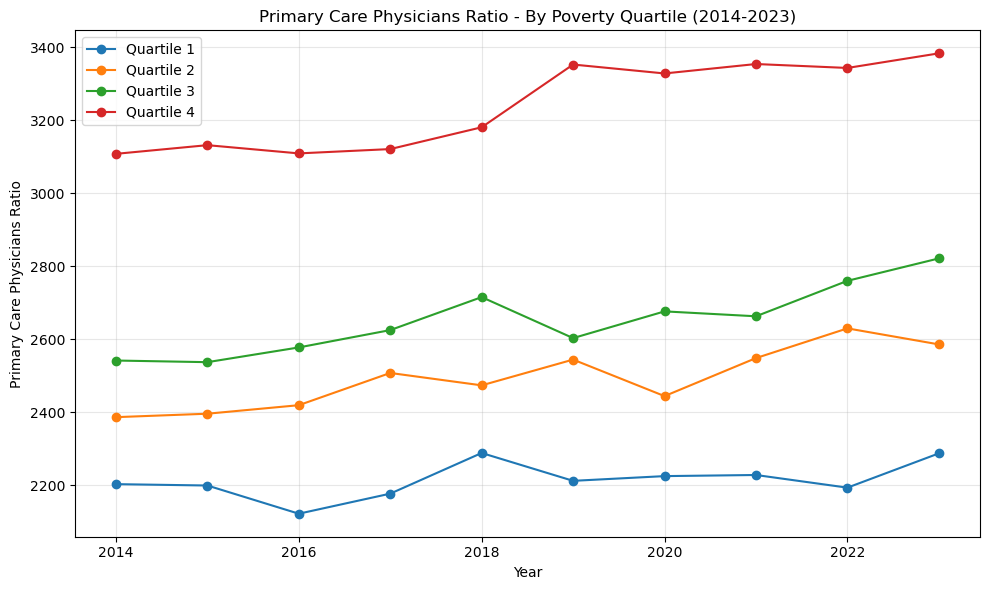

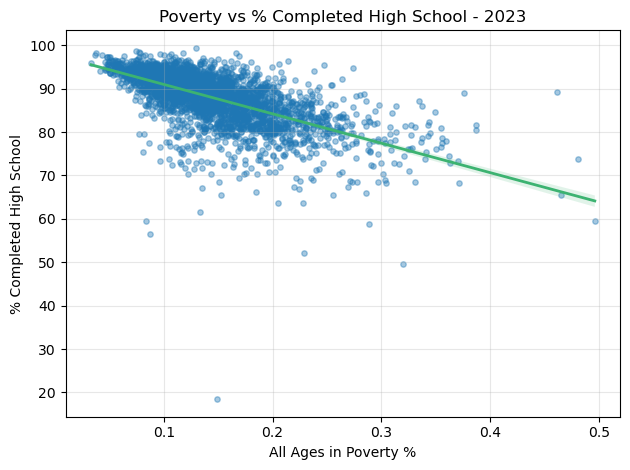

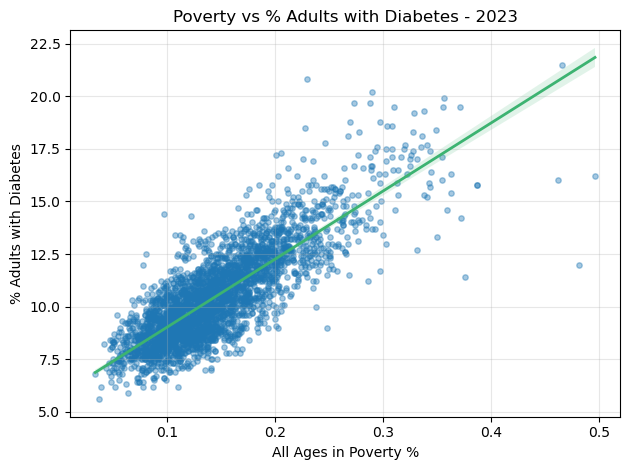

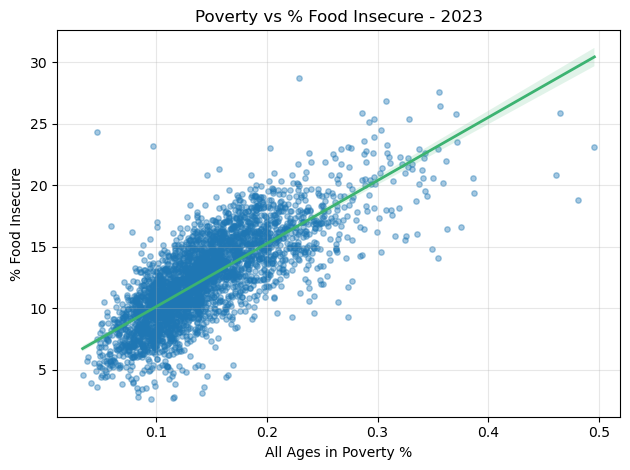

In 2023, the 3 features with the highest correlation to poverty rate are: ['% Fair or Poor Health', '% Adults with Diabetes', '% Food Insecure']


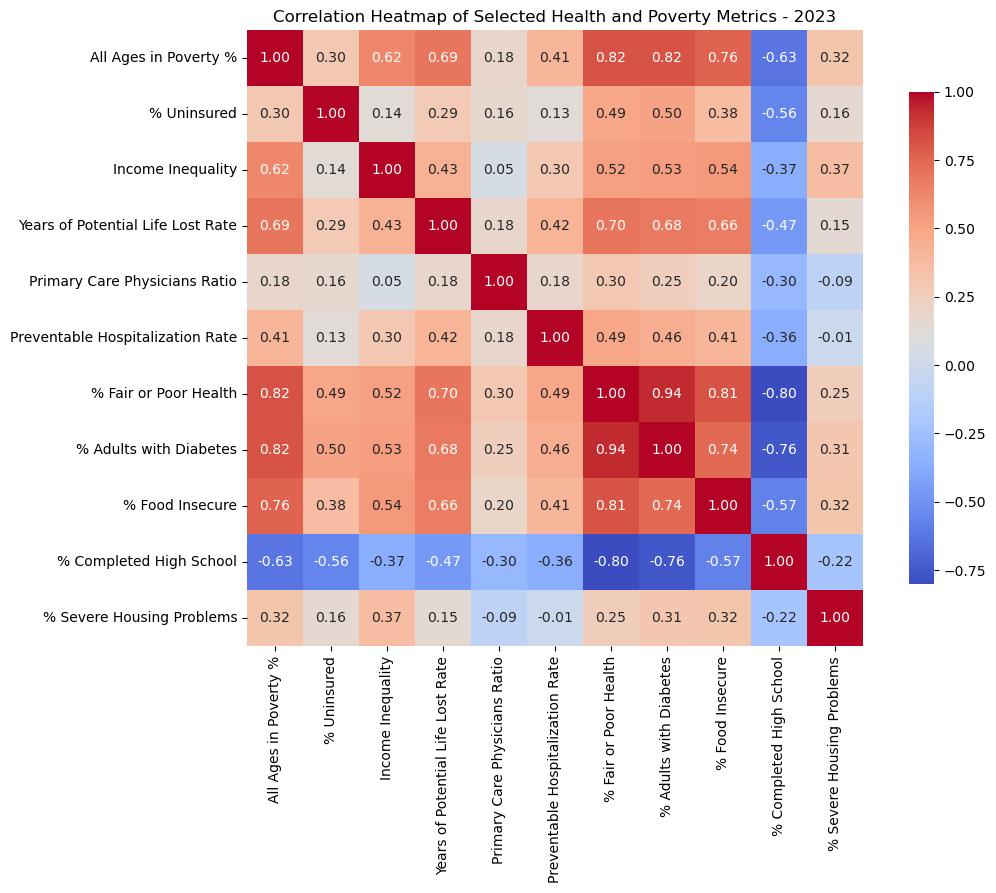

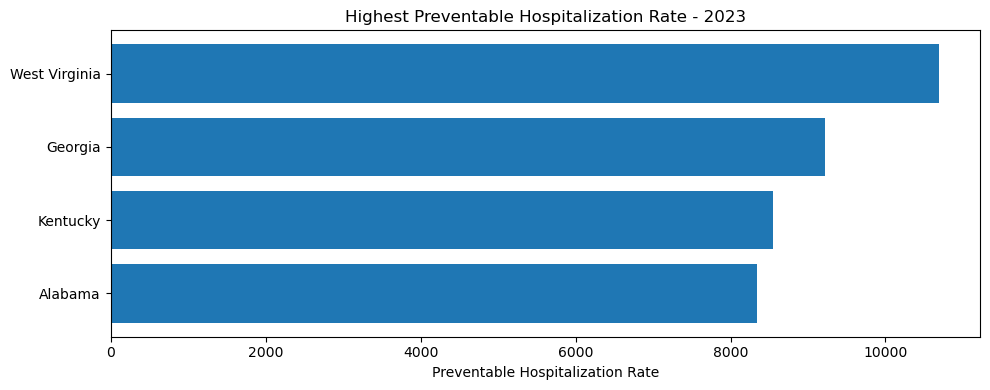

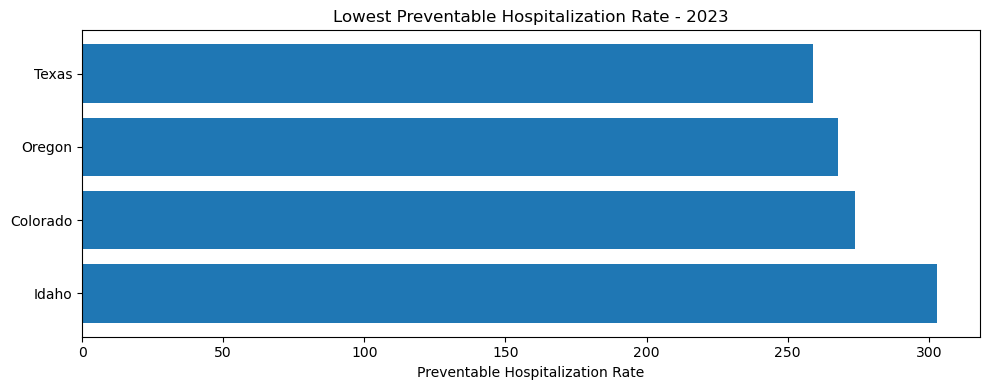

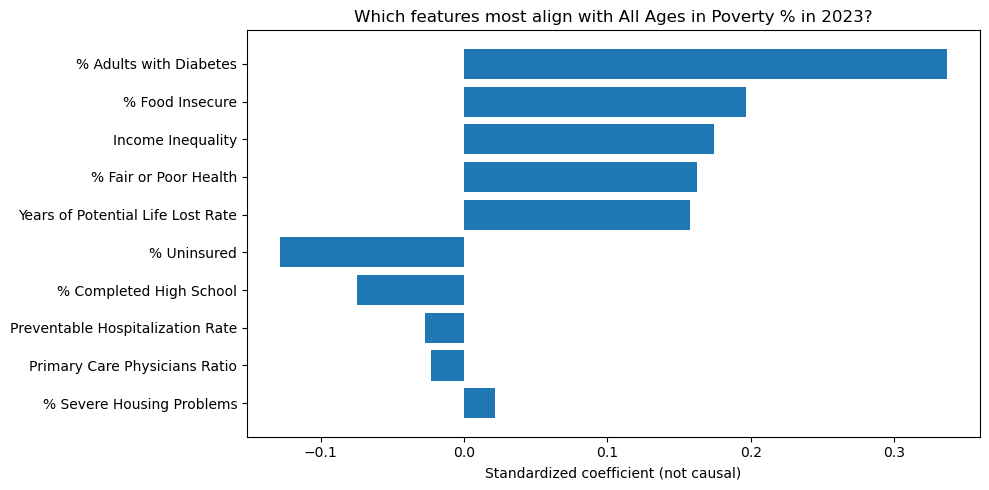

In [82]:
# choropleth map
print("The below choropleth shows the poverty quartile by county and \nevidencing that the southern United States has higher levels of poverty.")
choropleth_single_year(
    counties,
    last_year_df
)

# timeseries trends
for f in ["All Ages in Poverty %", "Income Inequality", "Primary Care Physicians Ratio"]:
    if f in features:
        plot_trend_by_quartile(yq_means, f)

# scatterplots
for f in ["% Completed High School", "% Adults with Diabetes", "% Food Insecure"]:
    if f in features:
        plot_scatter_poverty_with_trend(last_year_df, f)

# correlations heatmap
print(f"In {last_year_df['Year'].iloc[0]}, the 3 features with the highest correlation to poverty rate are: {last_year_df[features].corr()['All Ages in Poverty %'].abs().sort_values(ascending=False).index[1:4].tolist()}")
create_correlation_heatmap(last_year_df[features], f'Correlation Heatmap of Selected Health and Poverty Metrics - {last_year_df["Year"].iloc[0]}')

# extremes
if "Preventable Hospitalization Rate" in features:
    plot_extremes_bar(last_year_df, "Preventable Hospitalization Rate", top=5, bottom=5)

# feature importance horizontal bar chart
plot_feature_importance_simple(
    last_year_df,
    target="All Ages in Poverty %",
    candidate_features=[f for f in features if f != "All Ages in Poverty %"]
)


## Machine Learning Classification Models Implementation

### Implementing the different ML models

In [83]:
# creating ML dataframe, defining features(X) and target(y)
MLdf = allHealthData.copy()
target = "Poverty Quartile"
MLdf = MLdf[~MLdf[target].isna()]

X = MLdf[features]
y = MLdf[target].astype(str)

X.shape, y.shape

((31366, 11), (31366,))

In [84]:
# transforming and splitting data for ML models
# using Pipeline to ensure exact same steps are applied during cross-validation and to prevent leakage
preprocess = ColumnTransformer(
    transformers=[
        ("features", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())       # standardizing features which will be important for distance-based models like KNN and SVM
        ]), features),
    ],
    verbose_feature_names_out=False
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y     # stratisfy to maintain same class distribution in train and test sets
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25092, 11), (6274, 11), (25092,), (6274,))

In [85]:
# defining models to evaluate in a dictionary
models = {
    "KNN(k=15)": Pipeline([
        ("pre", preprocess),
        ("clf", KNeighborsClassifier(n_neighbors=15))   # mid-range of 15 neighbors to balance bias-variance tradeoff
    ]),
    "SupportVectorMachine": Pipeline([
        ("pre", preprocess),
        ("clf", SVC(kernel="rbf", random_state=42))
    ]),
    "DecisionTree": Pipeline([
        ("pre", preprocess),
        ("clf", DecisionTreeClassifier(min_samples_leaf=3, random_state=42))    # minimum samples per leaf to curb overfitting
    ]),
    "RandomForest": Pipeline([
        ("pre", preprocess),
        ("clf", RandomForestClassifier(
            n_estimators=400, min_samples_leaf=3,
            random_state=42
        ))
    ]),
}

In [94]:
# evaluating models using stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, pipe in models.items():
    scores = cross_validate(
        pipe, X_train, y_train,
        cv=skf,
        scoring={
            "prec_weighted": "precision_weighted",
            "rec_weighted": "recall_weighted"
            },
        n_jobs=-1, return_train_score=False
    )
    rows.append({
        "model": name,
        "cv_mean_precision_weighted": np.mean(scores["test_prec_weighted"]),
        "cv_mean_recall_weighted": np.mean(scores["test_rec_weighted"]),
    })

# sorting by balanced accuracy and f1_macro as poverty quartile classes are (likely) imbalanced and accuracy can be misleading
cv_table = pd.DataFrame(rows).sort_values(
    by=["cv_mean_precision_weighted", "cv_mean_recall_weighted"], ascending=False
).reset_index(drop=True)

display(cv_table)

,model,cv_mean_precision_weighted,cv_mean_recall_weighted
0,RandomForest,0.925522,0.925275
1,SupportVectorMachine,0.916369,0.915949
2,DecisionTree,0.894805,0.894588
3,KNN(k=15),0.793226,0.787741


### Choosing the best model, fitting it, predicting our test data, and evaluating the results in a confusion matrix

In [95]:
best_name = cv_table.iloc[0]["model"]
best_model = models[best_name]
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
labels = np.unique(y_test)

Best model: RandomForest
Weighted Precision:    0.923
Weighted Recall:       0.923

              precision    recall  f1-score   support

           1      0.952     0.958     0.955      1563
           2      0.898     0.879     0.888      1553
           3      0.887     0.897     0.892      1568
           4      0.955     0.958     0.957      1590

    accuracy                          0.923      6274
   macro avg      0.923     0.923     0.923      6274
weighted avg      0.923     0.923     0.923      6274



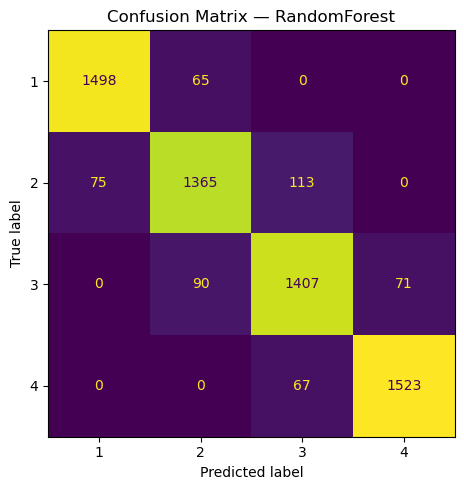

In [96]:
weighted_precision = round(precision_score(y_test, y_pred, average="weighted"), 3)
weighted_recall = round(recall_score(y_test, y_pred, average="weighted"), 3)

print(f"Best model: {best_name}")
print(f"Weighted Precision:    {weighted_precision}")
print(f"Weighted Recall:       {weighted_recall}\n")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, colorbar=False)
ax.set_title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()